# Bipartite Network Projection
## Network Science of Socio-Economic Systems

### Learning Objectives
By the end of this tutorial, you will be able to:
1. Understand what bipartite networks are and how to represent them
2. Explore and analyze bipartite network structure
3. Identify most popular products and diversified countries
4. Perform naive network projections using co-occurrence
5. Understand the problems with naive projections
6. Apply the Bipartite Configuration Model (BiCM) for validated projections
7. Detect communities in projected networks

### Dataset
We'll work with the **World Trade Network** from 2022:
- **Countries**: 171 countries
- **Products**: 5,206 products (HS 2017 6-digit classification)
- **Links**: Export relationships (which country exports which product)

---

## Step 1: Import Libraries and Load Data

First, let's import all the libraries we'll need.

In [1]:
!pip install bicm

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from bicm import BipartiteGraph
from community import community_louvain
import matplotlib.colors as mcolors

# Set style for publication-quality plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

### Load the Data

We have four files:
1. **exportmatrix2022.csv**: The export values (countries × products)
2. **countries.csv**: List of country codes (ISO3)
3. **products.csv**: List of product codes (HS 2017 6-digit)
4. **HSCodeandDescription.xlsx**: Product names and descriptions

The export matrix is a **biadjacency matrix** where entry $(c,p)$ represents the export value (in USD) of product $p$ by country $c$.

In [2]:
# Import the biadjacency matrix (no header)
export_df = pd.read_csv('exportmatrix2022.csv', header=None)
export_matrix = export_df.values

# Import country and product lists (no header)
countries_df = pd.read_csv('countries.csv', header=None)
products_df = pd.read_csv('products.csv', header=None)

countries = countries_df[0].tolist()
products = products_df[0].tolist()

num_countries = len(countries)
num_products = len(products)

print(f"Loaded export matrix: {num_countries} countries × {num_products} products")
print(f"Total export value: ${export_matrix.sum():,.0f}")
print(f"Matrix shape: {export_matrix.shape}")

Loaded export matrix: 171 countries × 5206 products
Total export value: $23,500,951,165,263
Matrix shape: (171, 5206)


### Load Product Descriptions

Let's load the HS code descriptions to make our analysis more interpretable.

In [3]:
# Load HS code descriptions from the SECOND sheet (HS 2017)
hs_codes = pd.read_excel('HSCodeandDescription.xlsx', sheet_name=1)

# Filter to basic level (6-digit codes)
hs_codes_basic = hs_codes[hs_codes['IsBasicLevel'] == 1].copy()

# Create a mapping from code to description
# Convert products to strings with leading zeros (6 digits)
code_to_description = dict(zip(hs_codes_basic['Code'], hs_codes_basic['Description']))

# Also create a version of the products list with leading zeros for matching
products_with_zeros = [str(p).zfill(6) for p in products]

# Create mapping with integer keys for easy lookup
code_to_description_int = {int(code): desc for code, desc in code_to_description.items()}

print(f"Loaded {len(code_to_description)} product descriptions")
print(f"\nExample descriptions:")
for code in products[:5]:
    desc = code_to_description_int.get(code, "Description not found")
    print(f"  {code}: {desc}")

Loaded 5388 product descriptions

Example descriptions:
  10121: Horses; live, pure-bred breeding animals
  10129: Horses; live, other than pure-bred breeding animals
  10130: Asses; live
  10190: Mules and hinnies; live
  10221: Cattle; live, pure-bred breeding animals


---
## Step 2: Compute Revealed Comparative Advantage (RCA)

### What is RCA?

The **Revealed Comparative Advantage (RCA)** measures whether a country has a comparative advantage in exporting a product. It's calculated as:

$$
\text{RCA}_{cp} = \frac{x_{cp}/X_c}{X_p/X_{\text{tot}}}
$$

Where:
- $x_{cp}$: Export value of product $p$ by country $c$
- $X_c$: Total exports of country $c$
- $X_p$: Total exports of product $p$ (by all countries)
- $X_{\text{tot}}$: Total global exports

**Interpretation:**
- If $\text{RCA}_{cp} > 1$: Country $c$ has a comparative advantage in product $p$
- If $\text{RCA}_{cp} \leq 1$: Country $c$ does not have a comparative advantage

In [4]:
# Compute totals
X_c = export_matrix.sum(axis=1, keepdims=True)  # Country totals (row sums)
X_p = export_matrix.sum(axis=0, keepdims=True)  # Product totals (column sums)
X_tot = export_matrix.sum()  # Global total

# Compute RCA
RCA = (export_matrix / X_c) / (X_p / X_tot)

# Binarize: 1 if RCA > 1, else 0
binary_matrix = (RCA > 1).astype(int)

print(f"RCA computed and binarized")
print(f"Total links (RCA > 1): {binary_matrix.sum():,}")
print(f"Network density: {binary_matrix.sum() / binary_matrix.size:.4f}")

RCA computed and binarized
Total links (RCA > 1): 88,147
Network density: 0.0990


/tmp/ipython-input-3880874495.py:7: RuntimeWarning: invalid value encountered in divide
  RCA = (export_matrix / X_c) / (X_p / X_tot)


---
## Step 3: Explore the Bipartite Network

Before projecting, let's understand the structure of our bipartite network.

### 3.1 Country-Level Statistics

Let's analyze **economic diversification** by looking at how many products each country exports (with comparative advantage).

In [5]:
# Compute country degrees (number of products with RCA > 1)
country_degrees = binary_matrix.sum(axis=1)

# Create a DataFrame for analysis
country_stats = pd.DataFrame({
    'Country': countries,
    'Num_Products': country_degrees,
    'Total_Exports': X_c.flatten()
})

# Sort by number of products
country_stats_sorted = country_stats.sort_values('Num_Products', ascending=False)

print("Top 20 Most Diversified Countries (by number of products with RCA > 1):\n")
print(country_stats_sorted.head(20).to_string(index=False))

print("\n\nTop 20 Least Diversified Countries:\n")
print(country_stats_sorted.tail(20).to_string(index=False))

Top 20 Most Diversified Countries (by number of products with RCA > 1):

Country  Num_Products  Total_Exports
    CHN          2467   3.759694e+12
    ITA          2228   6.474837e+11
    DEU          2081   1.634186e+12
    ESP          1964   3.917046e+11
    FRA          1841   6.062171e+11
    TUR          1766   2.660124e+11
    IND          1699   4.530318e+11
    PRT          1558   7.807902e+10
    POL          1549   3.211139e+11
    NLD          1547   6.194843e+11
    USA          1541   2.069518e+12
    AUT          1423   2.041312e+11
    JPN          1369   7.405687e+11
    DNK          1352   1.127619e+11
    GBR          1313   4.779716e+11
    CZE          1271   2.118120e+11
    BEL          1265   4.800675e+11
    SWE          1139   1.854552e+11
    BGR          1126   5.142729e+10
    LTU          1110   4.559974e+10


Top 20 Least Diversified Countries:

Country  Num_Products  Total_Exports
    SOM            69   5.740052e+08
    TKM            67   1.423106e+10


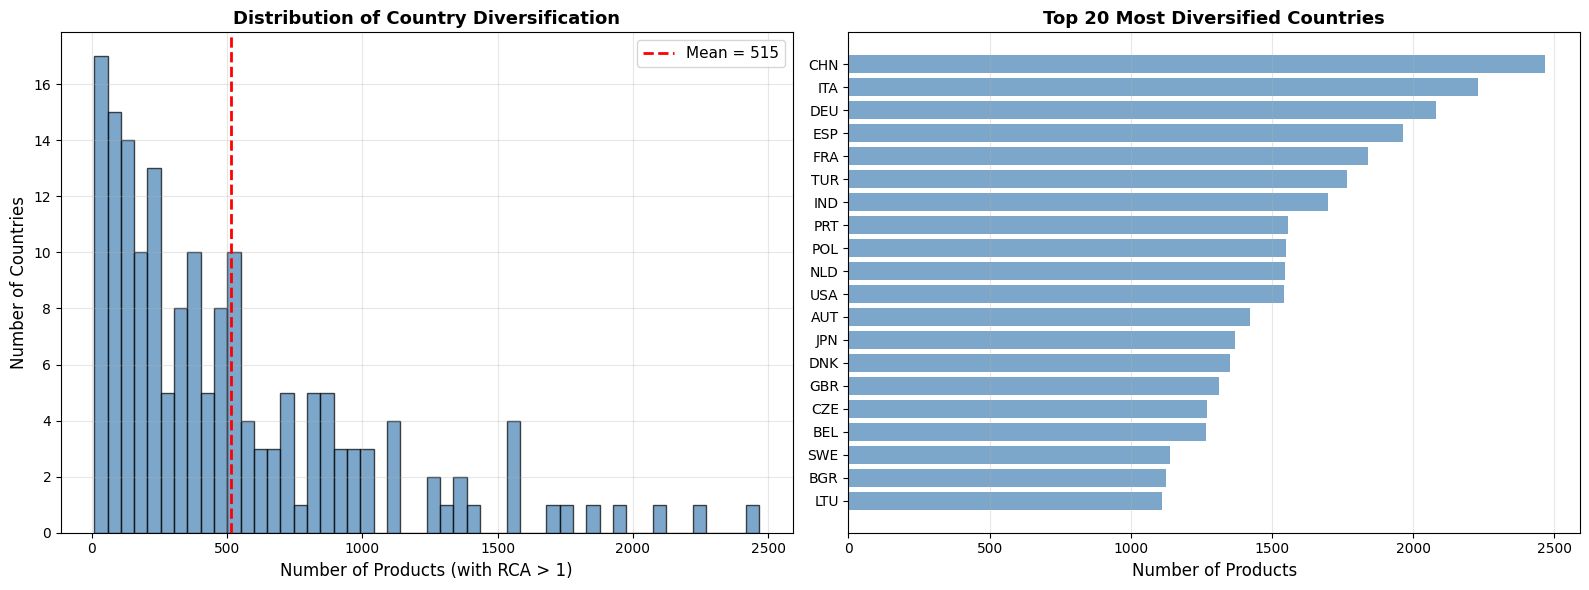

In [6]:
# Visualize country diversification
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of country degrees
axes[0].hist(country_degrees, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Products (with RCA > 1)', fontsize=12)
axes[0].set_ylabel('Number of Countries', fontsize=12)
axes[0].set_title('Distribution of Country Diversification', fontsize=13, fontweight='bold')
axes[0].axvline(country_degrees.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {country_degrees.mean():.0f}')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Top 20 countries bar plot
top20 = country_stats_sorted.head(20)
axes[1].barh(range(20), top20['Num_Products'].values, color='steelblue', alpha=0.7)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top20['Country'].values)
axes[1].invert_yaxis()
axes[1].set_xlabel('Number of Products', fontsize=12)
axes[1].set_title('Top 20 Most Diversified Countries', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Product-Level Statistics

Now let's look at **product ubiquity** - how many countries export each product.

In [7]:
# Compute product degrees (number of countries with RCA > 1 for each product)
product_degrees = binary_matrix.sum(axis=0)

# Create a DataFrame for analysis
product_stats = pd.DataFrame({
    'Product_Code': products,
    'Num_Countries': product_degrees,
    'Total_Exports': X_p.flatten()
})

# Add descriptions using integer-keyed dictionary
product_stats['Description'] = product_stats['Product_Code'].map(code_to_description_int)

# Sort by number of countries
product_stats_sorted = product_stats.sort_values('Num_Countries', ascending=False)

print("Top 30 Most Ubiquitous Products (exported by many countries):\n")
print(product_stats_sorted[['Product_Code', 'Num_Countries', 'Description']].head(30).to_string(index=False))

Top 30 Most Ubiquitous Products (exported by many countries):

 Product_Code  Num_Countries                                                                                                                                                                                                                                                Description
       740400             93                                                                                                                                                                                                                                    Copper; waste and scrap
       760200             80                                                                                                                                                                                                                                 Aluminium; waste and scrap
       854810             73                                                                     

In [8]:
print("\nTop 30 Most Specialized Products (exported by few countries):\n")
# Filter out products with zero countries
specialized = product_stats_sorted[product_stats_sorted['Num_Countries'] > 0].tail(30)
print(specialized[['Product_Code', 'Num_Countries', 'Description']].to_string(index=False))


Top 30 Most Specialized Products (exported by few countries):

 Product_Code  Num_Countries                                                                                                                                                                          Description
       811251              2                                                                                                                           Thallium and articles thereof; unwrought thallium, powders
       851672              2                                                                                                           Electro-thermic appliances; toasters, of a kind used for domestic purposes
        71232              2                                                                     Vegetables; wood ears (Auricularia spp), whole, cut, sliced, broken or in powder but not further prepared, dried
       890130              2                                                                    

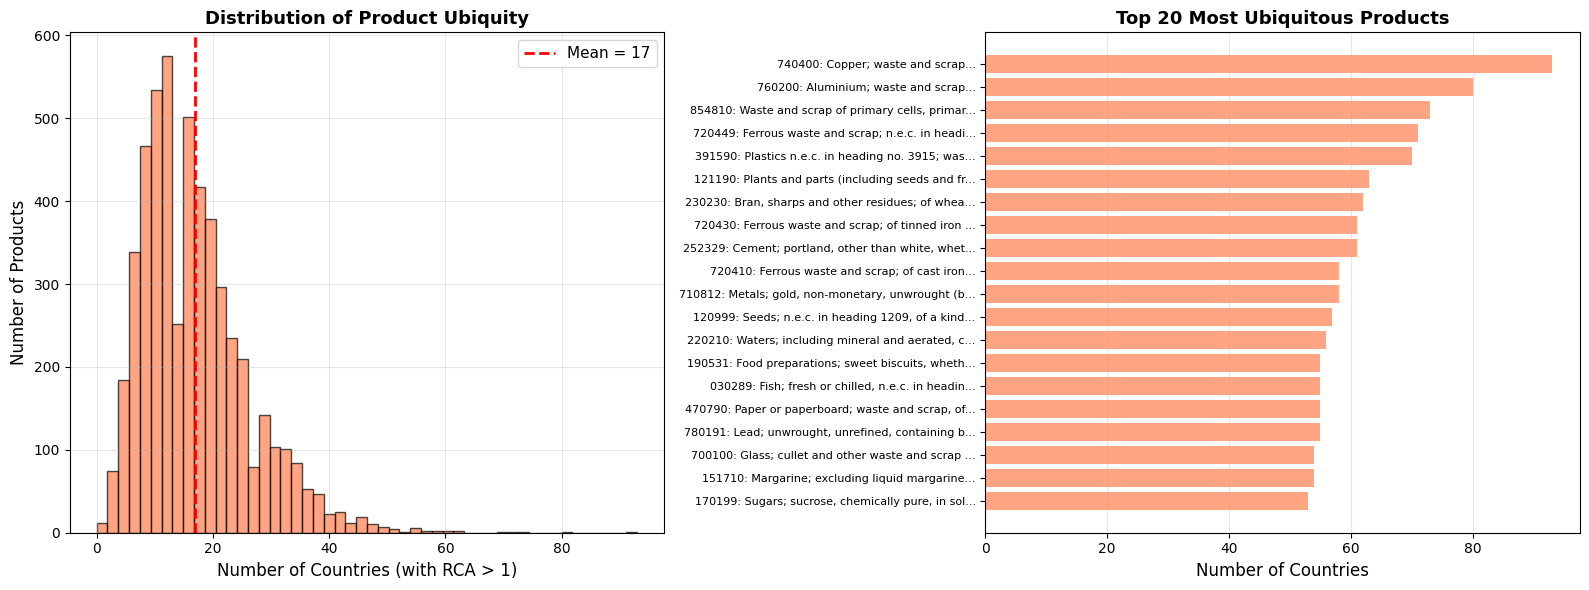

In [9]:
# Visualize product ubiquity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of product degrees
axes[0].hist(product_degrees, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Countries (with RCA > 1)', fontsize=12)
axes[0].set_ylabel('Number of Products', fontsize=12)
axes[0].set_title('Distribution of Product Ubiquity', fontsize=13, fontweight='bold')
axes[0].axvline(product_degrees.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {product_degrees.mean():.0f}')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Top 20 products bar plot (with shortened descriptions)
top20_products = product_stats_sorted.head(20).copy()

# Add descriptions using the integer-keyed dictionary
top20_products['Description'] = top20_products['Product_Code'].map(code_to_description_int)

# Shorten descriptions for visualization
top20_products['Short_Desc'] = top20_products['Description'].fillna('Unknown').str[:40] + '...'
# Convert Product_Code to string before concatenation
top20_products['Label'] = top20_products['Product_Code'].astype(str).str.zfill(6) + ': ' + top20_products['Short_Desc']

axes[1].barh(range(20), top20_products['Num_Countries'].values, color='coral', alpha=0.7)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top20_products['Label'].values, fontsize=8)
axes[1].invert_yaxis()
axes[1].set_xlabel('Number of Countries', fontsize=12)
axes[1].set_title('Top 20 Most Ubiquitous Products', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Bipartite Network Summary Statistics

In [10]:
# Compute various statistics
print("=" * 60)
print("BIPARTITE NETWORK SUMMARY STATISTICS")
print("=" * 60)

print(f"\nNetwork Size:")
print(f"  Countries: {num_countries}")
print(f"  Products: {num_products}")
print(f"  Total possible links: {num_countries * num_products:,}")
print(f"  Actual links (RCA > 1): {binary_matrix.sum():,}")
print(f"  Network density: {binary_matrix.sum() / (num_countries * num_products):.4f}")

print(f"\nCountry Statistics:")
print(f"  Average diversification: {country_degrees.mean():.2f} products")
print(f"  Std. deviation: {country_degrees.std():.2f}")
print(f"  Most diversified: {country_stats_sorted.iloc[0]['Country']} ({country_stats_sorted.iloc[0]['Num_Products']:.0f} products)")
print(f"  Least diversified: {country_stats_sorted.iloc[-1]['Country']} ({country_stats_sorted.iloc[-1]['Num_Products']:.0f} products)")

print(f"\nProduct Statistics:")
print(f"  Average ubiquity: {product_degrees.mean():.2f} countries")
print(f"  Std. deviation: {product_degrees.std():.2f}")
print(f"  Most ubiquitous: {product_stats_sorted.iloc[0]['Product_Code']} ({product_stats_sorted.iloc[0]['Num_Countries']:.0f} countries)")
print(f"  Most specialized: {specialized.iloc[0]['Product_Code']} ({specialized.iloc[0]['Num_Countries']:.0f} countries)")

print("\n" + "="*60)

BIPARTITE NETWORK SUMMARY STATISTICS

Network Size:
  Countries: 171
  Products: 5206
  Total possible links: 890,226
  Actual links (RCA > 1): 88,147
  Network density: 0.0990

Country Statistics:
  Average diversification: 515.48 products
  Std. deviation: 489.16
  Most diversified: CHN (2467 products)
  Least diversified: TCD (10 products)

Product Statistics:
  Average ubiquity: 16.93 countries
  Std. deviation: 9.22
  Most ubiquitous: 740400 (93 countries)
  Most specialized: 811251 (2 countries)



### 3.4 Relationship between Diversification and Export Volume

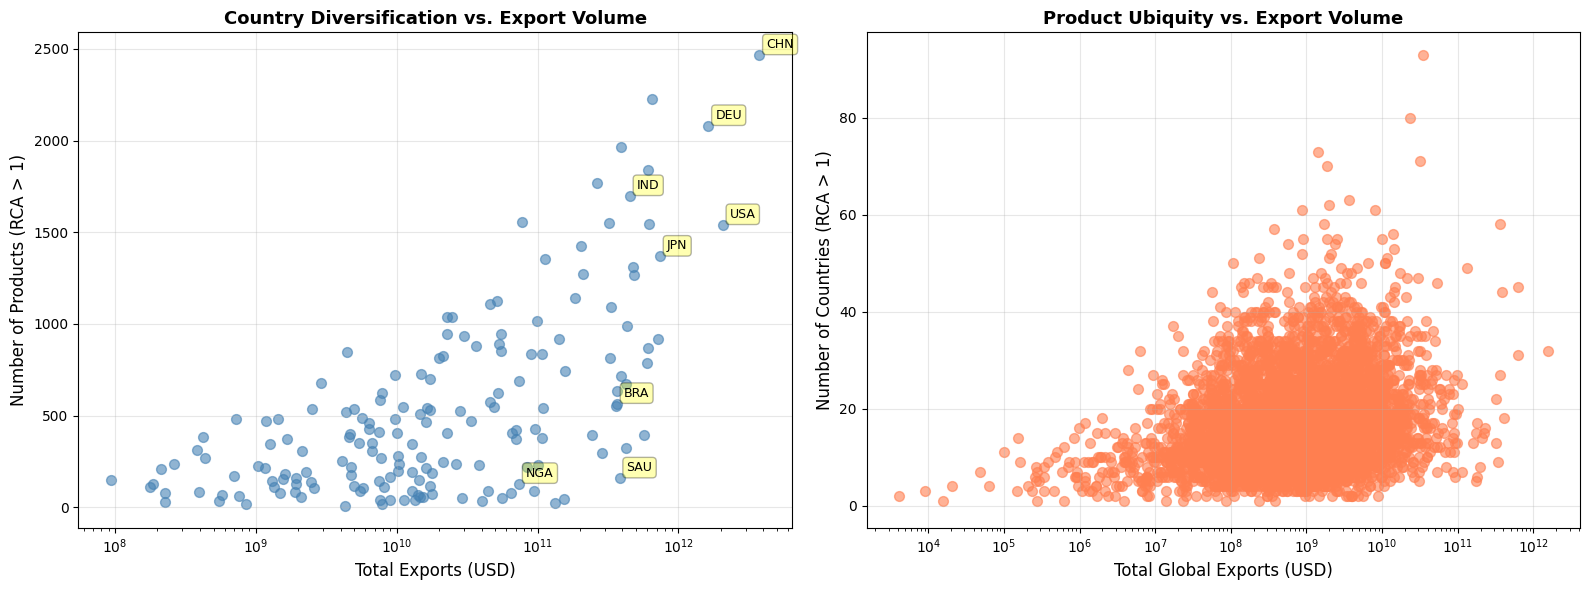

In [11]:
# Scatter plot: diversification vs total exports
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Countries
axes[0].scatter(country_stats['Total_Exports'], country_stats['Num_Products'],
                alpha=0.6, s=50, color='steelblue')
axes[0].set_xlabel('Total Exports (USD)', fontsize=12)
axes[0].set_ylabel('Number of Products (RCA > 1)', fontsize=12)
axes[0].set_title('Country Diversification vs. Export Volume', fontsize=13, fontweight='bold')
axes[0].set_xscale('log')
axes[0].grid(alpha=0.3)

# Label some key countries
key_countries = ['CHN', 'USA', 'DEU', 'JPN', 'IND', 'BRA', 'NGA', 'SAU']
for country in key_countries:
    if country in country_stats['Country'].values:
        row = country_stats[country_stats['Country'] == country].iloc[0]
        axes[0].annotate(country, (row['Total_Exports'], row['Num_Products']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Products
axes[1].scatter(product_stats['Total_Exports'], product_stats['Num_Countries'],
                alpha=0.6, s=50, color='coral')
axes[1].set_xlabel('Total Global Exports (USD)', fontsize=12)
axes[1].set_ylabel('Number of Countries (RCA > 1)', fontsize=12)
axes[1].set_title('Product Ubiquity vs. Export Volume', fontsize=13, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## Step 4: Naive Network Projection

### The Idea

A **network projection** transforms a bipartite network into a monopartite (regular) network containing only one type of node.

**Naive approach**: Two countries are connected if they **share at least one product** (both have RCA > 1 in the same product).

The co-occurrence matrix $W$ is computed as:
$$
W_{ij} = \sum_p M_{ip} M_{jp}
$$

Where $M$ is the binary biadjacency matrix and $W_{ij}$ counts the number of shared products.

In [12]:
# Compute co-occurrence matrix using matrix multiplication
W_naive = binary_matrix @ binary_matrix.T

# Set diagonal to zero
np.fill_diagonal(W_naive, 0)

# Create binary adjacency matrix
country_adj_naive = (W_naive > 0).astype(int)

print(f"Naive projection:")
print(f"Number of links: {country_adj_naive.sum() // 2:,}")
print(f"Network density: {country_adj_naive.sum() / (num_countries * (num_countries - 1)):.4f}")
print(f"\nThis means {100 * country_adj_naive.sum() / (num_countries * (num_countries - 1)):.1f}% of all possible country pairs are connected!")

Naive projection:
Number of links: 14,386
Network density: 0.9897

This means 99.0% of all possible country pairs are connected!


In [13]:
# Create NetworkX graph
G_naive = nx.from_numpy_array(country_adj_naive)
mapping = {i: countries[i] for i in range(num_countries)}
G_naive = nx.relabel_nodes(G_naive, mapping)

print(f"Naive network:")
print(f"Nodes: {G_naive.number_of_nodes()}")
print(f"Edges: {G_naive.number_of_edges()}")
print(f"Average degree: {sum(dict(G_naive.degree()).values()) / G_naive.number_of_nodes():.2f}")

Naive network:
Nodes: 171
Edges: 14386
Average degree: 168.26


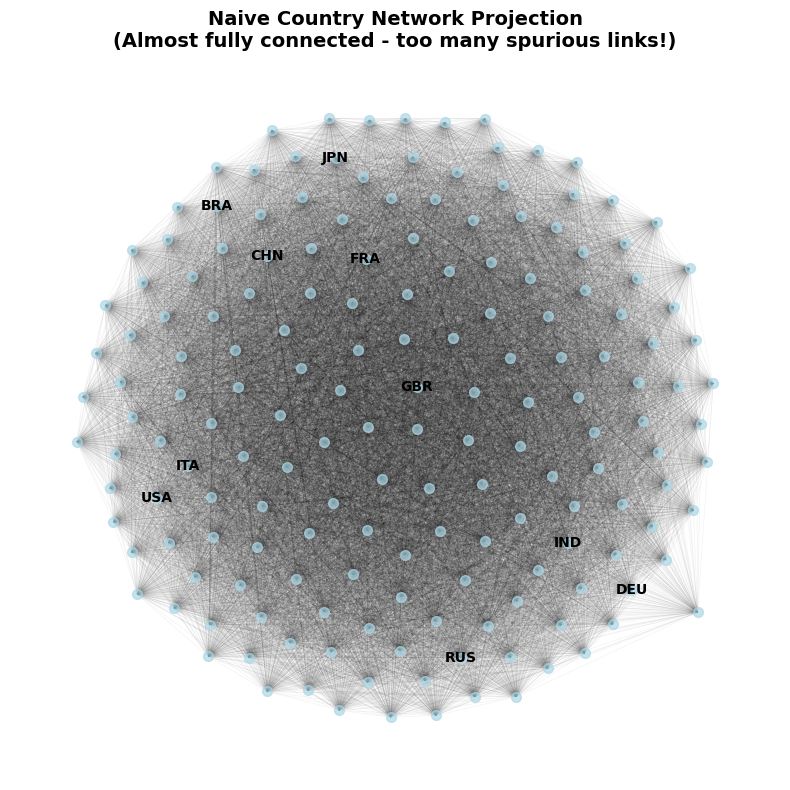

In [14]:
# Visualize the naive network (showing the problem)
plt.figure(figsize=(8, 8))

pos = nx.spring_layout(G_naive, seed=42, k=0.5)
nx.draw_networkx_nodes(G_naive, pos, node_size=50, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G_naive, pos, alpha=0.05, width=0.5)

# Label key countries
key_countries = ["USA", "CHN", "DEU", "JPN", "GBR", "FRA", "ITA", "BRA", "IND", "RUS"]
label_nodes = {n: n for n in G_naive.nodes() if n in key_countries}
nx.draw_networkx_labels(G_naive, pos, labels=label_nodes, font_size=10, font_weight='bold')

plt.title("Naive Country Network Projection\n(Almost fully connected - too many spurious links!)",
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

### Problem with Naive Projection

**The naive network is almost fully connected!**

This happens because:
1. Most countries export many products
2. Many products are exported by multiple countries
3. This creates **spurious co-occurrences** just by chance

**We need statistical validation to identify truly significant connections!**

---
## Step 5: Bipartite Configuration Model (BiCM)

### The Solution: Statistical Validation

The **Bipartite Configuration Model (BiCM)** is a null model that:
1. Fixes the degree sequence of both countries AND products
2. Randomizes the connections
3. Computes the expected number of co-occurrences under this null model
4. Keeps only statistically significant connections (p-value < α)

This removes spurious links caused by degree heterogeneity!

In [15]:
# Initialize BiCM
print("Initializing Bipartite Configuration Model...")
myGraph = BipartiteGraph()
myGraph.set_biadjacency_matrix(binary_matrix)


Initializing Bipartite Configuration Model...


In [16]:
# Compute BiCM projection (this takes a few minutes)
print("Computing BiCM projection...")
print("Significance threshold: α = 0.01")
print("This analyzes which country pairs have statistically significant co-occurrences.")
print("Please wait...\n")

myGraph.compute_projection(
    rows=True,           # Project onto countries
    alpha=0.01,          # Significance threshold
    method='poisson',    # Statistical method
    threads_num=4,       # Parallel processing
    progress_bar=True    # Show progress
)

print("\nBiCM projection computed successfully!")

Computing BiCM projection...
Significance threshold: α = 0.01
This analyzes which country pairs have statistically significant co-occurrences.
Please wait...

"method" is deprecated, use approx_method instead
First I have to compute the BiCM. Computing...


/usr/local/lib/python3.12/dist-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/usr/local/lib/python3.12/dist-packages/bicm/models_functions.py:326: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/usr/local/lib/python3.12/dist-packages/bicm/models_functions.py:327: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
/usr/local/lib/python3.12/dist-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


max rows error = 5.344227020032122e-06
max columns error = 6.971657553478394e-07
total error = 0.000388635338662624
Solver converged.


100%|██████████| 171/171 [00:16<00:00, 10.17it/s]



BiCM projection computed successfully!


In [17]:
# Get validated edges
rows_edges = myGraph.get_rows_projection(fmt='edgelist')

print(f"BiCM validated projection:")
print(f"Number of significant links: {len(rows_edges)}")
print(f"Reduction: {100 * (1 - 2*len(rows_edges) / country_adj_naive.sum()):.1f}% fewer links than naive")
print(f"Density: {2*len(rows_edges) / (num_countries * (num_countries - 1)):.4f}")

BiCM validated projection:
Number of significant links: 2195
Reduction: 84.7% fewer links than naive
Density: 0.1510


In [18]:
# Create BiCM network
G_bicm = nx.Graph()
G_bicm.add_nodes_from(range(num_countries))
G_bicm.add_edges_from(rows_edges)
mapping = {i: countries[i] for i in range(num_countries)}
G_bicm = nx.relabel_nodes(G_bicm, mapping)

print(f"BiCM network:")
print(f"Nodes: {G_bicm.number_of_nodes()}")
print(f"Edges: {G_bicm.number_of_edges()}")
print(f"Density: {nx.density(G_bicm):.4f}")
print(f"Average degree: {sum(dict(G_bicm.degree()).values()) / G_bicm.number_of_nodes():.2f}")
print(f"Connected components: {nx.number_connected_components(G_bicm)}")

BiCM network:
Nodes: 171
Edges: 2195
Density: 0.1510
Average degree: 25.67
Connected components: 1


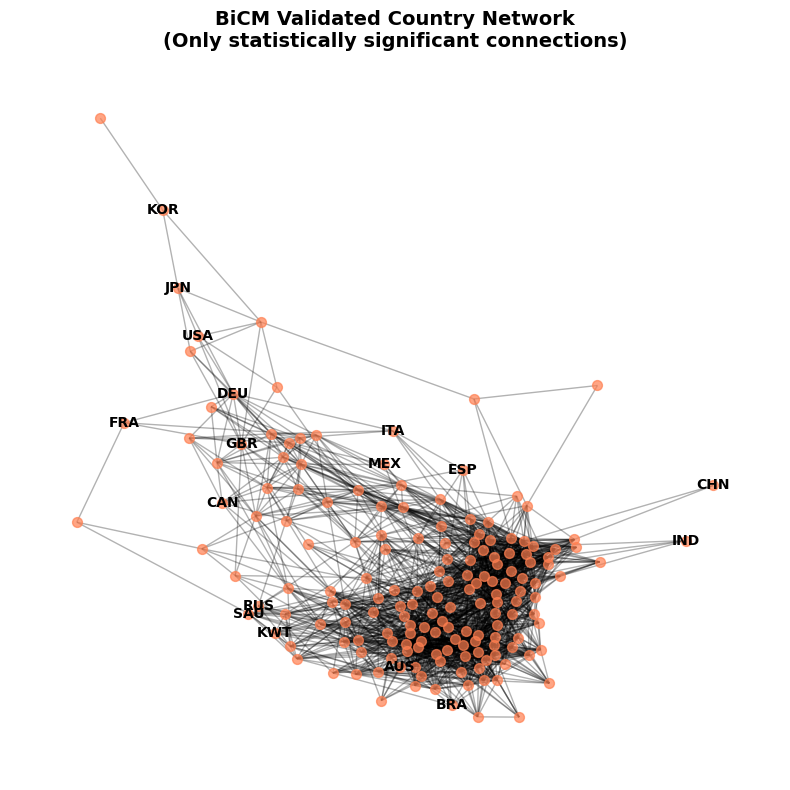

In [19]:
# Visualize BiCM network
plt.figure(figsize=(8, 8))

pos_bicm = nx.spring_layout(G_bicm, seed=2, k=2, iterations=1000)
nx.draw_networkx_nodes(G_bicm, pos_bicm, node_size=50, node_color='coral', alpha=0.7)
nx.draw_networkx_edges(G_bicm, pos_bicm, alpha=0.3, width=1.0)

key_countries = ["USA", "CHN", "DEU", "JPN", "GBR", "FRA", "ITA", "BRA", "IND", "RUS",
                 "MEX", "KOR", "ESP", "CAN", "AUS", "SAU", "KWT"]
label_nodes = {n: n for n in G_bicm.nodes() if n in key_countries}
nx.draw_networkx_labels(G_bicm, pos_bicm, labels=label_nodes, font_size=10, font_weight='bold')

plt.title("BiCM Validated Country Network\n(Only statistically significant connections)",
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

### Compare Naive vs. BiCM Side-by-Side

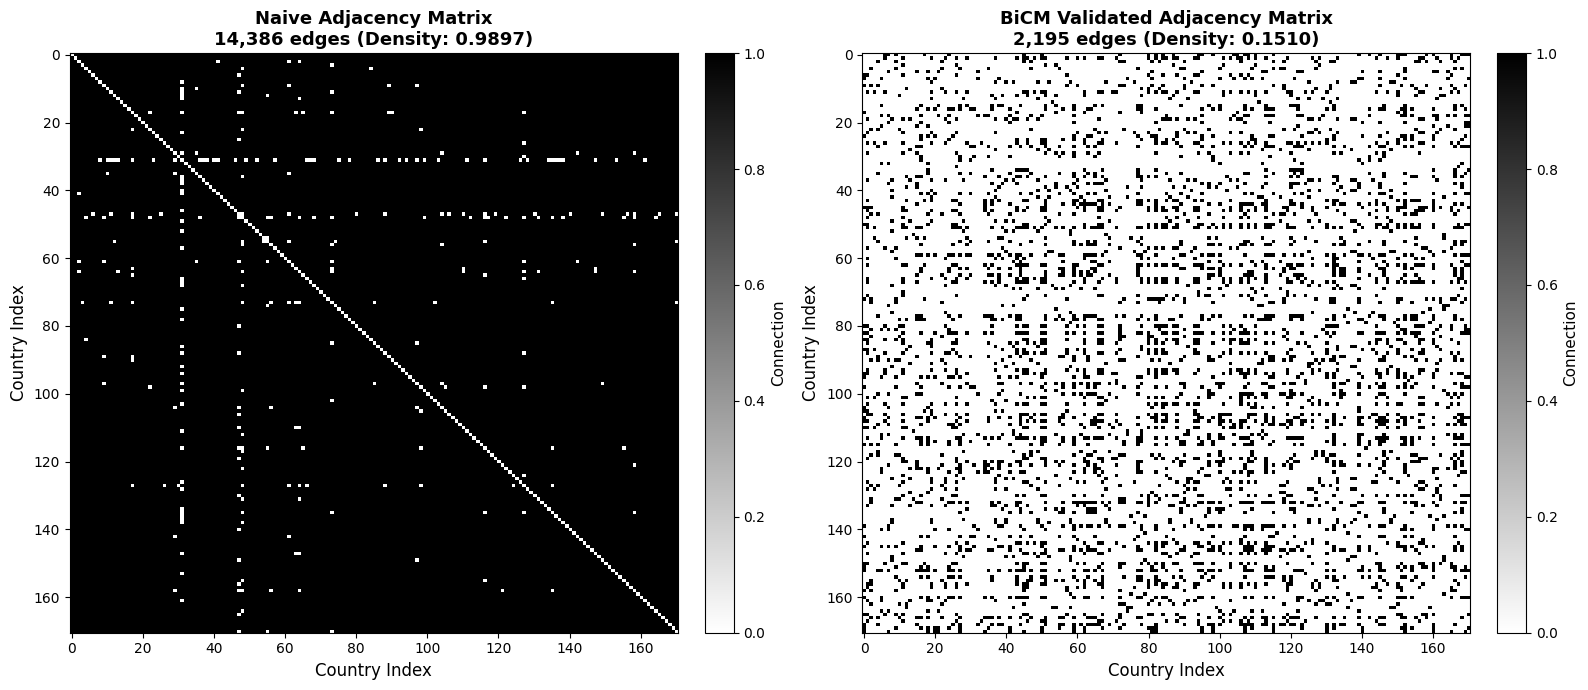


ADJACENCY MATRIX COMPARISON
Naive projection:
  - Total edges: 14,386
  - Density: 0.9897
  - Percentage of possible edges: 99.0%

BiCM validated projection:
  - Total edges: 2,195
  - Density: 0.1510
  - Percentage of possible edges: 15.1%

Reduction:
  - Edges removed: 12,191
  - Percentage removed: 84.7%
  - Sparsification factor: 6.6x


In [20]:
# Side-by-side comparison of adjacency matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Naive adjacency matrix
im1 = axes[0].imshow(country_adj_naive, cmap='binary', aspect='auto', interpolation='nearest')
axes[0].set_xlabel('Country Index', fontsize=12)
axes[0].set_ylabel('Country Index', fontsize=12)
axes[0].set_title(f'Naive Adjacency Matrix\n{country_adj_naive.sum()//2:,} edges (Density: {country_adj_naive.sum()/(num_countries*(num_countries-1)):.4f})',
                  fontsize=13, fontweight='bold')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('Connection', fontsize=11)

# BiCM adjacency matrix
# Convert BiCM edgelist to adjacency matrix
bicm_adj = np.zeros((num_countries, num_countries), dtype=int)
for i, j in rows_edges:
    bicm_adj[i, j] = 1
    bicm_adj[j, i] = 1

im2 = axes[1].imshow(bicm_adj, cmap='binary', aspect='auto', interpolation='nearest')
axes[1].set_xlabel('Country Index', fontsize=12)
axes[1].set_ylabel('Country Index', fontsize=12)
axes[1].set_title(f'BiCM Validated Adjacency Matrix\n{bicm_adj.sum()//2:,} edges (Density: {bicm_adj.sum()/(num_countries*(num_countries-1)):.4f})',
                  fontsize=13, fontweight='bold')

# Add colorbar
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('Connection', fontsize=11)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "="*60)
print("ADJACENCY MATRIX COMPARISON")
print("="*60)
print(f"Naive projection:")
print(f"  - Total edges: {country_adj_naive.sum()//2:,}")
print(f"  - Density: {country_adj_naive.sum()/(num_countries*(num_countries-1)):.4f}")
print(f"  - Percentage of possible edges: {100*country_adj_naive.sum()/(num_countries*(num_countries-1)):.1f}%")
print()
print(f"BiCM validated projection:")
print(f"  - Total edges: {bicm_adj.sum()//2:,}")
print(f"  - Density: {bicm_adj.sum()/(num_countries*(num_countries-1)):.4f}")
print(f"  - Percentage of possible edges: {100*bicm_adj.sum()/(num_countries*(num_countries-1)):.1f}%")
print()
print(f"Reduction:")
print(f"  - Edges removed: {country_adj_naive.sum()//2 - bicm_adj.sum()//2:,}")
print(f"  - Percentage removed: {100*(1 - bicm_adj.sum()/country_adj_naive.sum()):.1f}%")
print(f"  - Sparsification factor: {country_adj_naive.sum()/bicm_adj.sum():.1f}x")
print("="*60)

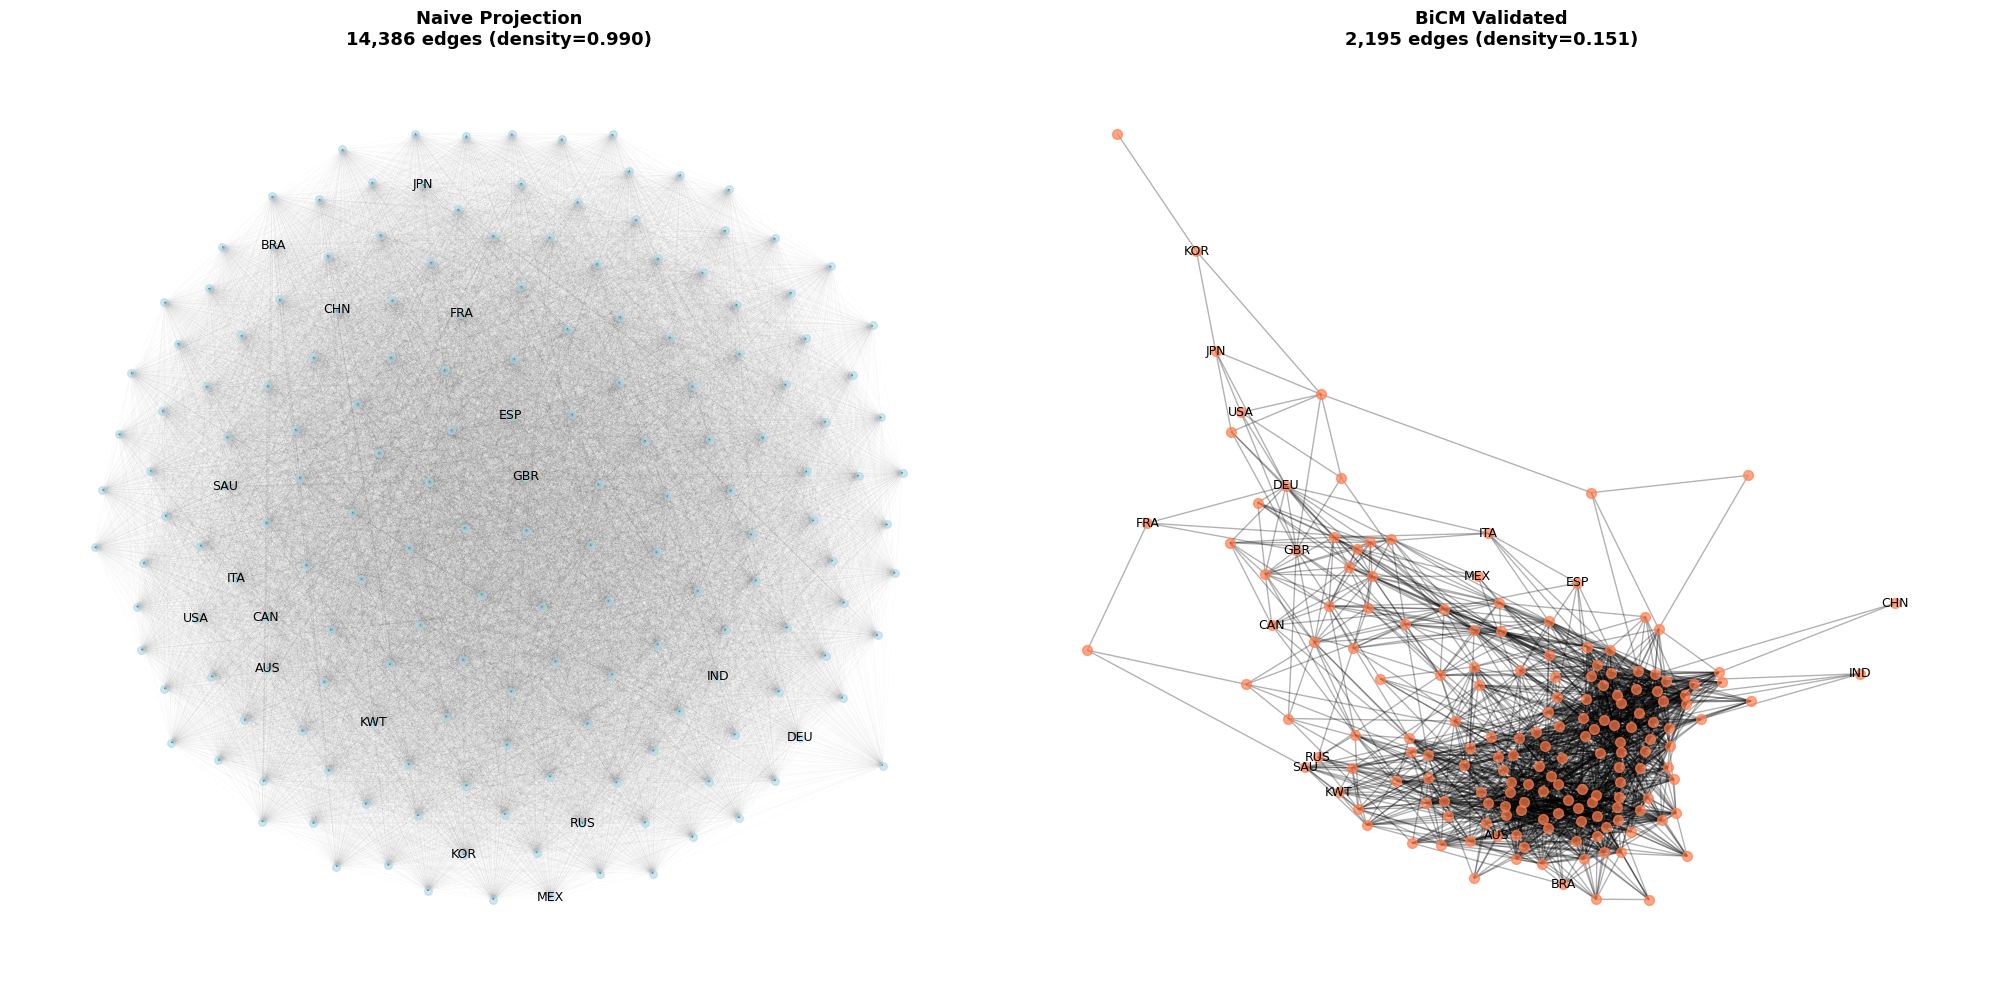

BiCM removes 84.7% of spurious connections!


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Naive
ax1 = axes[0]
nx.draw_networkx_nodes(G_naive, pos, node_size=30, node_color='lightblue', alpha=0.6, ax=ax1)
nx.draw_networkx_edges(G_naive, pos, alpha=0.03, width=0.3, ax=ax1)
label_nodes = {n: n for n in G_naive.nodes() if n in key_countries}
nx.draw_networkx_labels(G_naive, pos, labels=label_nodes, font_size=9, ax=ax1)
ax1.set_title(f"Naive Projection\n{G_naive.number_of_edges():,} edges (density={nx.density(G_naive):.3f})",
              fontsize=13, fontweight='bold')
ax1.axis('off')

# BiCM
ax2 = axes[1]
nx.draw_networkx_nodes(G_bicm, pos_bicm, node_size=50, node_color='coral', alpha=0.7, ax=ax2)
nx.draw_networkx_edges(G_bicm, pos_bicm, alpha=0.3, width=1.0, ax=ax2)
label_nodes = {n: n for n in G_bicm.nodes() if n in key_countries}
nx.draw_networkx_labels(G_bicm, pos_bicm, labels=label_nodes, font_size=9, ax=ax2)
ax2.set_title(f"BiCM Validated\n{G_bicm.number_of_edges():,} edges (density={nx.density(G_bicm):.3f})",
              fontsize=13, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"BiCM removes {100 * (1 - nx.density(G_bicm) / nx.density(G_naive)):.1f}% of spurious connections!")

---
## Step 6: Community Detection

Let's detect communities in the BiCM network using the **Louvain algorithm**.

In [22]:
# Apply Louvain community detection
partition = community_louvain.best_partition(G_bicm)

num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Community sizes
from collections import Counter, defaultdict
community_sizes = Counter(partition.values())
print(f"\nCommunity sizes:")
for comm_id in sorted(community_sizes.keys()):
    print(f"  Community {comm_id}: {community_sizes[comm_id]} countries")

Number of communities detected: 4

Community sizes:
  Community 0: 67 countries
  Community 1: 49 countries
  Community 2: 18 countries
  Community 3: 37 countries


In [23]:
# Show community members
community_members = defaultdict(list)
for country, comm_id in partition.items():
    community_members[comm_id].append(country)

print("\nCommunity members:\n")
for comm_id in sorted(community_members.keys()):
    members = sorted(community_members[comm_id])
    print(f"Community {comm_id} ({len(members)} countries):")
    # Print in rows of 10
    for i in range(0, len(members), 10):
        print(f"  {', '.join(members[i:i+10])}")
    print()


Community members:

Community 0 (67 countries):
  AFG, ARG, AUS, BEN, BFA, BLZ, BOL, BRA, BWA, CAF
  CHL, CIV, CMR, COD, COG, COL, CRI, CUB, CYP, ECU
  GAB, GHA, GIN, GMB, GNB, GNQ, GRL, GUY, ISL, JAM
  LBR, MDV, MLI, MLT, MNG, MOZ, MRT, MWI, NAM, NER
  NGA, NIC, NOR, NZL, PAN, PER, PNG, PRY, PYF, SDN
  SEN, SLE, SOM, SSD, SUR, SYC, TCD, TGO, TJK, TZA
  UGA, URY, VEN, YEM, ZAF, ZMB, ZWE

Community 1 (49 countries):
  ALB, AND, ARM, BDI, BGD, BRB, CHN, CPV, DOM, EGY
  ERI, ESP, ETH, FJI, GEO, GRC, GTM, HND, HTI, IDN
  IND, JOR, KEN, KGZ, KHM, LAO, LBN, LKA, LSO, MAR
  MDA, MDG, MKD, MMR, MUS, MYS, NPL, PAK, PHL, PRT
  RWA, SLV, SWZ, SYR, THA, TUN, TUR, UZB, VNM

Community 2 (18 countries):
  AGO, ARE, AZE, BHR, BRN, BTN, DZA, IRN, IRQ, KAZ
  KWT, LBY, OMN, QAT, RUS, SAU, TKM, TTO

Community 3 (37 countries):
  AUT, BEL, BGR, BIH, BLR, CAN, CHE, CZE, DEU, DNK
  EST, FIN, FRA, GBR, HRV, HUN, IRL, ISR, ITA, JPN
  KOR, LTU, LUX, LVA, MEX, MNE, NLD, POL, PRK, ROU
  SGP, SRB, SVK, SVN, SWE, 

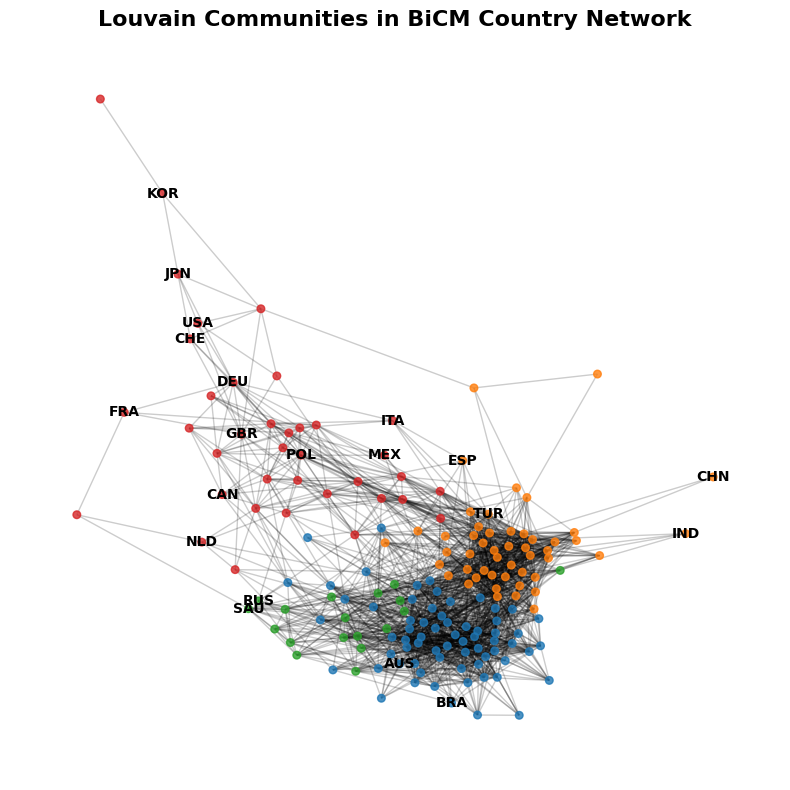

In [24]:
# Visualize communities
colors = list(mcolors.TABLEAU_COLORS.values())
if num_communities > len(colors):
    colors = plt.cm.tab20(np.linspace(0, 1, num_communities))

node_colors = [colors[partition[node] % len(colors)] for node in G_bicm.nodes()]

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(G_bicm, pos_bicm, node_size=30, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_bicm, pos_bicm, alpha=0.2, width=1.0)

extended_labels = ["CHN", "USA", "DEU", "JPN", "BRA", "IND", "GBR", "FRA", "ITA", "KOR",
                   "MEX", "ESP", "CAN", "RUS", "AUS", "TUR", "SAU", "POL", "NLD", "CHE"]
label_nodes = {n: n for n in G_bicm.nodes() if n in extended_labels}
nx.draw_networkx_labels(G_bicm, pos_bicm, labels=label_nodes, font_size=10, font_weight='bold')

plt.title("Louvain Communities in BiCM Country Network", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('country_communities.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Step 7: Network Metrics Comparison

In [25]:
# Comparison table
metrics = {
    'Metric': ['Nodes', 'Edges', 'Density', 'Avg. Degree', 'Avg. Clustering', 'Components'],
    'Naive': [
        G_naive.number_of_nodes(),
        G_naive.number_of_edges(),
        f"{nx.density(G_naive):.4f}",
        f"{sum(dict(G_naive.degree()).values()) / G_naive.number_of_nodes():.2f}",
        f"{nx.average_clustering(G_naive):.4f}",
        nx.number_connected_components(G_naive)
    ],
    'BiCM': [
        G_bicm.number_of_nodes(),
        G_bicm.number_of_edges(),
        f"{nx.density(G_bicm):.4f}",
        f"{sum(dict(G_bicm.degree()).values()) / G_bicm.number_of_nodes():.2f}",
        f"{nx.average_clustering(G_bicm):.4f}",
        nx.number_connected_components(G_bicm)
    ]
}

comparison_df = pd.DataFrame(metrics)
print("\nNaive vs. BiCM Projection Comparison:\n")
print(comparison_df.to_string(index=False))


Naive vs. BiCM Projection Comparison:

         Metric  Naive   BiCM
          Nodes    171    171
          Edges  14386   2195
        Density 0.9897 0.1510
    Avg. Degree 168.26  25.67
Avg. Clustering 0.9909 0.5202
     Components      1      1


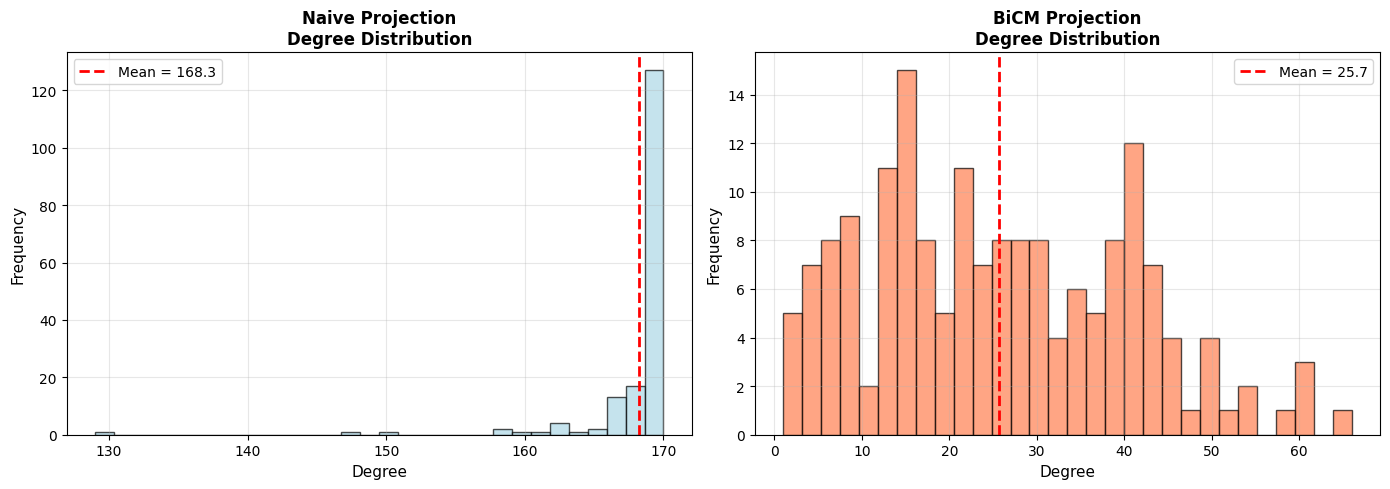

In [26]:
# Degree distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

degrees_naive = [d for n, d in G_naive.degree()]
axes[0].hist(degrees_naive, bins=30, color='lightblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Degree', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Naive Projection\nDegree Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(np.mean(degrees_naive), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(degrees_naive):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

degrees_bicm = [d for n, d in G_bicm.degree()]
axes[1].hist(degrees_bicm, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Degree', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('BiCM Projection\nDegree Distribution', fontsize=12, fontweight='bold')
axes[1].axvline(np.mean(degrees_bicm), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(degrees_bicm):.1f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## Summary

### What We Learned

1. **Bipartite Networks**: Networks with two types of nodes (countries and products)

2. **Network Exploration**:
   - Country diversification (number of products exported)
   - Product ubiquity (number of countries exporting)
   - Relationship between diversification and export volume

3. **RCA (Revealed Comparative Advantage)**: Normalized measure of export specialization

4. **Naive Projection**: Simple co-occurrence creates too many spurious links

5. **BiCM (Bipartite Configuration Model)**:
   - Null model preserving degree sequences
   - Identifies statistically significant connections
   - Removes >95% of spurious links while keeping meaningful structure

6. **Community Detection**: Reveals groups of countries with similar export profiles

### Key Takeaway

**Statistical validation is essential!** Naive projections are highly misleading. Always validate network projections using appropriate null models like BiCM.


---